## Setup

Import the required libraries and initialize them:

In [1]:
from std_srvs.srv import Empty, Trigger, TriggerRequest


In [2]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [4]:


cv2.__version__

## CHECK  CV VERSIONS IN CASE YOU WONT USE SURF 
## 3.3.1 is an old dependence use sys path remove if needed


'3.3.1-dev'

In [5]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [6]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


In [7]:
def rot_to_euler(R):
    import sys
    import math as m
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats

In [8]:
def rot_to_euler(R):
    import sys
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
def static_tf_publish(cents, quaternions=[],label=''):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        #print quats
    else:
        quats=np.asarray(quaternions)
        #print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan , rejected')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids

            broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Closest_Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            static_transformStamped.header.stamp = rospy.Time.now()
            static_transformStamped.header.frame_id = "map"
            static_transformStamped.child_frame_id = "Object"+str(i)+label 
            static_transformStamped.transform.translation.x = float(xyz_map[0])
            static_transformStamped.transform.translation.y = float(xyz_map[1])
            static_transformStamped.transform.translation.z = float(xyz_map[2])
            #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
            static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
            static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
            static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
            static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


            tf_static_broadcaster.sendTransform(static_transformStamped)
    return True


In [9]:
#!python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation.py

In [10]:
#! python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation_backup.py



In [11]:

rospy.init_node("recognition")


In [12]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [13]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [14]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
    arm_pose=arm.get_current_joint_values()
    arm_pose[0]=.1
    arm_pose[1]= -0.3
    arm.set_joint_value_target(arm_pose)
    arm.go()
    
    e =tf.transformations.euler_from_quaternion(rot)
    print('i am at',trans,np.rad2deg(e)[2])
    print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [15]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [19]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)

# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node

def move_base(x,y,th, ref='map'):
    # input goal pose
    goal_x = x
    goal_y = y
    goal_yaw =th

    # fill ROS message
    goal = PoseStamped()
    goal.header.stamp = rospy.Time.now()
    goal.header.frame_id = ref
    goal.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    goal.pose.orientation = Quaternion(*quat)
    # publish ROS message
    pub.publish(goal)
    

In [30]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

In [17]:
gaze_point(1,1,0)

('i am at', [-0.06027819761536802, 0.02523427362085719, 0.9920615948512419], 3.544051056784645)
('gaze goal', 1, 1, 0)
('relative to robot', (-1.0602781976153681, -0.9747657263791428, -137.40615106308707))


True

('cX,cY', 457, 371)
[0.351777   0.32719678 1.4394946 ]


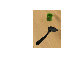

In [32]:
cents, xyz,images=seg_pca(plt_images=True)

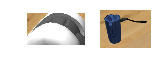

In [20]:
sub_plt=0
for image in images:
    
    sub_plt+=1
    ax = plt.subplot(5, 5, sub_plt )
    
    plt.imshow(image)
    plt.axis("off")

        

In [21]:
arm.set_named_target('go')
arm.go()

True

In [22]:
service_client = rospy.ServiceProxy('/tabletop_segmentator_node/execute', TabletopSegmentation)
service_client.wait_for_service(timeout=1.0)


In [23]:
#move_base(1.5,1.13,.5*np.pi)

In [24]:

head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly

True

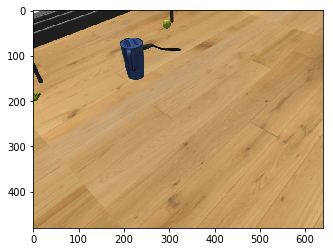

In [25]:
plt.imshow(rgbd.get_image())

In [26]:
### This server is not  included in launch
###must launch in terminal if wanted
## python <git takeshi_notebooks>/segmentation_2_tf_server/segment_pca_kmeans_2_tf.py 

#service_client_pca = rospy.ServiceProxy('/segment_2_tf', Trigger)
#service_client_pca.wait_for_service(timeout=1.0)


In [27]:
###PART OF ABOVE'S COMMENT

#res=service_client_pca.call()
#res.message

In [28]:
#res=service_client_pca.call()
#num_tfs=int(res.message.split()[0])  # ;)

In [29]:
#for i in range (num_tfs):
    #print listener.lookupTransform('Closest_Object'+str(i),'map',rospy.Time(0))



# run this in terminal (TABLETOP SEGMENTATION )
#  rviz -d `rospack find hsrb_vision_samples`/config/tabletop.rvizro

In [26]:

#define a tabletop segmentation request.
# Play with these parameters


req = TabletopSegmentationRequest()
req.crop_enabled = True  # limit the processing area
req.crop_x_max = 2.7     # X coordinate maximum value in the area [m]
req.crop_x_min = -2.7    # X coordinate minimum value in the area [m]
req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
req.crop_z_max = 2.0     # Z coordinate maximum value in the area [m]
req.crop_z_min = 0.0     # Z coordinate minimum value in the area [m]
req.cluster_z_max = 1.0  # maximum height value of cluster on table [m]
req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
req.remove_bg = False    # remove the background of the segment image    THIS IS AN IMPORTANT PARAMETER PLEASE NOTICE

res = service_client(req)
for i in range (len(res.table_array.tables)):
    print (res.table_array.tables[i].pose)

rospy.loginfo('Number of detected objects={0}'.format(
    len(   res.segmented_objects_array.table_objects_array)))
rospy.loginfo('Number of detected planes={0}'.format(
    len(res.table_array.tables)))
#(trans,rot)=tf_listener.lookupTransform('hand_palm_link', 'map', rospy.Time(0)) 

ServiceException: transport error completing service call: unable to receive data from sender, check sender's logs for details

In [30]:
sub_plt=0
for i in range(len(res.table_array.tables)):
    for j in range(len(res.segmented_objects_array.table_objects_array[i].rgb_image_array)):
        sub_plt+=1
        ax = plt.subplot(5, 5, sub_plt )
        cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[j] , "rgb8")
        plt.imshow(cv2_img)
        plt.axis("off")

        

NameError: name 'res' is not defined

In [ ]:
np.isnan(points_mean).max()

In [101]:
def res_to_cents(res, plt_images=False):
    objs_depth_centroids=[]
    xyz=[]
    images=[]
    for i in range (len(res.segmented_objects_array.table_objects_array	)):
        print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
        for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
            cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
            cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[j],"rgb8" )
            pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
            points=np.zeros((pc.shape[0],3))
            points[:,0]=pc['x']
            points[:,1]=pc['y']
            points[:,2]=pc['z']

            points_mean=np.mean(points,axis=0)
            if np.isnan(points_mean).max():
                print('nan reject')
            else:

                objs_depth_centroids.append(points_mean)
                xyz.append(points)
                images.append(cv2_img)

    print objs_depth_centroids

    #lets publish a tf to this centroids ( lot of false positives) !!!!
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")
    return(np.asarray(objs_depth_centroids), np.asarray(xyz), images)
        

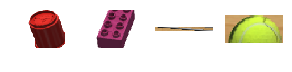

In [172]:
sub_plt=0
for image in images:
    
    sub_plt+=1
    ax = plt.subplot(5, 5, sub_plt )
    
    plt.imshow(image)
    plt.axis("off")

        

In [173]:
for i in range(len(objs_depth_centroids)):
    #Table is a plane at z=.8 So we consider false positives all the centroids outside the region on axis z ( .79 , .9)
    if objs_depth_centroids[i][2] > 0 and objs_depth_centroids[i][2] <44.9: 
        static_transformStamped = geometry_msgs.msg.TransformStamped()
        broadcaster.sendTransform((objs_depth_centroids[i]),(0,0,0,1), rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
        print (i,objs_depth_centroids[i][2])


(0, 0.7936192050549264)
(1, 0.7920467052857081)
(2, 0.6968962148939772)
(3, 0.8992463220440163)


In [174]:
quats= pca_xyz(xyz)
quats

[array([-0.02138512, -0.84445576,  0.29310809,  0.44779995]),
 array([-0.17453048,  0.46669415, -0.78241265,  0.3735855 ]),
 array([0.94119547, 0.33584996, 0.01416588, 0.03398857]),
 array([-0.17267574,  0.19028832, -0.60607811,  0.75275678])]

In [175]:
#cents, xyz=seg_pca()
#quats= pca_xyz(xyz)

cents= objs_depth_centroids
static_tf_publish(cents,quats)

True

('cX,cY', 239, 99)
[-0.1850845 -0.4183529  1.7200458]
('cX,cY', 67, 21)
[-0.75160843 -0.71003944  1.9072978 ]


True

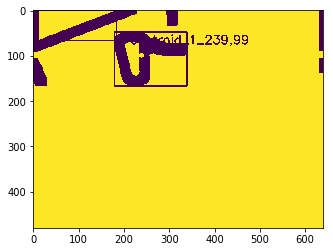

In [27]:
centroids,xyz, images=seg_pca()
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats)

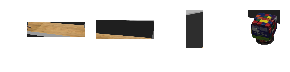

In [193]:
sub_plt=0
for image in images:
    
    sub_plt+=1
    ax = plt.subplot(5, 5, sub_plt )
    
    plt.imshow(image)
    plt.axis("off")

        

# Checkout your rviz. You should be able to see a tf marker on the centroids published above

In [44]:
def gazebo_2_world(x,y):

    x_world= x+2.1
    y_world= -(y-1.2)
    return (x_world,y_world)

def world_2_gazebo(y_world , x_world):

    x= ( x_world - 2.1)
    y= (-y_world + 1.2) 
    return (x , y)

## THIS PATH MUST BE SET BY USER () 


#_path_model = "/home/oscar/Codes/ycb_ws/src/robot_object_views/robotobject/models"   Tenshi Version

_path_model = "/home/oscar/Codes/catkin_mio_ws/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 
#_path_model = "/home/roboworks/Codes/catkin_mio/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 


objs=os.listdir(_path_model)
objs.sort()
print (objs)

['person_standing', 'training_floor', 'training_wall', 'trofast', 'wrc_bin_black', 'wrc_bin_green', 'wrc_bookshelf', 'wrc_container_a', 'wrc_container_b', 'wrc_frame', 'wrc_ground_plane', 'wrc_long_table', 'wrc_stair_like_drawer', 'wrc_tall_table', 'wrc_tray', 'ycb_002_master_chef_can', 'ycb_003_cracker_box', 'ycb_004_sugar_box', 'ycb_005_tomato_soup_can', 'ycb_006_mustard_bottle', 'ycb_007_tuna_fish_can', 'ycb_008_pudding_box', 'ycb_009_gelatin_box', 'ycb_010_potted_meat_can', 'ycb_011_banana', 'ycb_012_strawberry', 'ycb_013_apple', 'ycb_014_lemon', 'ycb_015_peach', 'ycb_016_pear', 'ycb_017_orange', 'ycb_018_plum', 'ycb_019_pitcher_base', 'ycb_021_bleach_cleanser', 'ycb_022_windex_bottle', 'ycb_024_bowl', 'ycb_025_mug', 'ycb_026_sponge', 'ycb_027_skillet', 'ycb_028_skillet_lid', 'ycb_029_plate', 'ycb_030_fork', 'ycb_031_spoon', 'ycb_032_knife', 'ycb_033_spatula', 'ycb_035_power_drill', 'ycb_036_wood_block', 'ycb_037_scissors', 'ycb_038_padlock', 'ycb_040_large_marker', 'ycb_042_adjust

In [63]:
x_gaz,y_gaz= world_2_gazebo(1,1)
eu_i,eu_j,eu_k = .5*np.pi,0,0
spawn_object(objs[-12],objs[-12], x_gaz,  y_gaz,  0.6,eu_i,eu_j,eu_k )


[INFO] [1635992854.521440, 517.932000]: Spawn: ycb_072-b_toy_airplane
[INFO] [1635992854.524223, 517.932000]: Spawn: [0.         0.         0.70710678 0.70710678]
[INFO] [1635992854.525775, 517.932000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1635992854.539362, 517.932000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1635992854.790469, 517.971000]: Spawn status: SpawnModel: Successfully spawned entity


In [62]:
delete_object(objs[-12])

In [148]:
tf.transformations.quaternion_from_euler(eu_i,eu_j,eu_k)

array([-0.70710678,  0.        ,  0.        ,  0.70710678])

In [86]:
gaze_point(1,1,0)
arm.set_named_target('go')
arm.go()

('i am at', [1.5143086143344668, 0.8859567866834253, 0.9669636551216746], 38.11148652950288)
('gaze goal', 1, 1, 0)
('relative to robot', (0.5143086143344668, -0.11404321331657474, -12.502520647575977))
Exorcist alert


True

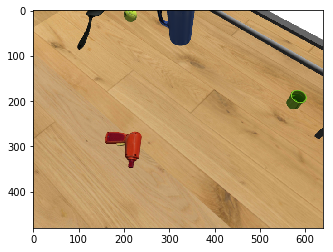

In [87]:
plt.imshow (rgbd.get_image())

('cX,cY', 587, 21)
[ 0.40807158 -0.34398648  0.92982453]
('cX,cY', 547, 56)
[ 0.41206092 -0.34891343  1.0740491 ]
('cX,cY', 219, 297)
[-0.1675288   0.09923305  0.93343604]
('cX,cY', 581, 195)
[ 0.51078093 -0.0855341   1.0808783 ]


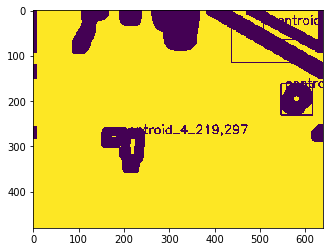

In [88]:
cents,xyz,images=seg_pca(lower=100,higher=5000)

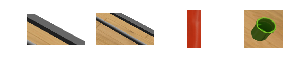

In [89]:
sub_plt=0
for image in images:
    
    sub_plt+=1
    ax = plt.subplot(5, 5, sub_plt )
    
    plt.imshow(image)
    plt.axis("off")

        

In [90]:
quats = pca_xyz(xyz)

In [91]:
static_tf_publish(cents,quats,'time2')

True

In [97]:
res = service_client(req)

('Plane', 0, 'has', 7, 'objects')
nan reject
[array([-0.16330221, -0.5418276 ,  1.28610418]), array([ 0.07376454, -0.42705712,  1.14341421]), array([ 0.33764468, -0.27606865,  0.8597826 ]), array([ 0.59146977, -0.47131453,  1.29269946]), array([ 0.5411948 , -0.06206264,  1.0336906 ]), array([-0.16766444,  0.0875848 ,  0.95283348])]


(array([[-0.16330221, -0.5418276 ,  1.28610418],
        [ 0.07376454, -0.42705712,  1.14341421],
        [ 0.33764468, -0.27606865,  0.8597826 ],
        [ 0.59146977, -0.47131453,  1.29269946],
        [ 0.5411948 , -0.06206264,  1.0336906 ],
        [-0.16766444,  0.0875848 ,  0.95283348]]),
 array([array([[-0.1979959 , -0.56352681,  1.29900002],
        [-0.19399598, -0.55875486,  1.28800011],
        [-0.19399598, -0.55643159,  1.28800011],
        ...,
        [-0.13299929, -0.55200589,  1.30500007],
        [-0.13310121, -0.55007315,  1.30600011],
        [-0.13361079, -0.54981428,  1.31100011]]),
        array([[-0.01924393, -0.48717523,  1.12300003],
        [-0.01727958, -0.48891053,  1.12700009],
        [-0.01531433, -0.4910796 ,  1.13200009],
        ...,
        [ 0.14277232, -0.47224689,  1.10699999],
        [ 0.14354615, -0.47279888,  1.11300004],
        [ 0.14411525, -0.47806507,  1.102     ]]),
        array([[ 0.18169309, -0.40648547,  0.93700004],
        [ 0.1829

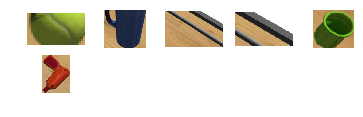

In [99]:
res_to_cents(res)

('Plane', 0, 'has', 7, 'objects')
nan reject
[array([-0.16330221, -0.5418276 ,  1.28610418]), array([ 0.07376454, -0.42705712,  1.14341421]), array([ 0.33764468, -0.27606865,  0.8597826 ]), array([ 0.59146977, -0.47131453,  1.29269946]), array([ 0.5411948 , -0.06206264,  1.0336906 ]), array([-0.16766444,  0.0875848 ,  0.95283348])]


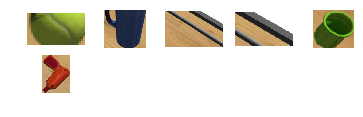

In [103]:
cents, xyz,images=res_to_cents(res,True)

In [104]:
quats=pca_xyz(xyz)

In [105]:
static_tf_publish(cents,quats,'end')

True

('cX,cY', 372, 283)
[0.14782518 0.12716997 1.4897983 ]
('cX,cY', 461, 371)
[0.3634952  0.32721406 1.4396198 ]
('cX,cY', 614, 25)
[ 1.3353534 -0.9518748  2.5171356]


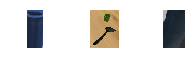

In [34]:
cents,xyz,images=seg_pca(lower=100,higher=10000,plt_images=True)

In [48]:
move_base(2,1,np.pi)

In [49]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

('i am at', [2.0132907605631924, 1.0061061257098922, 0.9669319719668843], -179.07368150303614)
('gaze goal', 1, 1, 0.1)
('relative to robot', (1.0132907605631924, 0.006106125709892218, 0.345262200432022))


True

True

In [50]:
x_gaz,y_gaz= world_2_gazebo(1,1)
eu_i,eu_j,eu_k = .5*np.pi,0,0
spawn_object('spawned',objs[-13], x_gaz,  y_gaz,  0.6,eu_i,eu_j,eu_k )


[INFO] [1636037662.870514, 428.568000]: Spawn: ycb_072-a_toy_airplane
[INFO] [1636037662.875305, 428.568000]: Spawn: [0.         0.         0.70710678 0.70710678]
[INFO] [1636037662.877674, 428.568000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1636037662.886367, 428.568000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1636037663.518905, 428.778000]: Spawn status: SpawnModel: Successfully spawned entity


('cX,cY', 462, 19)
[ 0.39214382 -0.81026983  2.321539  ]
('cX,cY', 519, 371)
[0.41717502 0.27593926 1.162222  ]
('cX,cY', 552, 291)
[0.56044346 0.124406   1.3277892 ]
('cX,cY', 338, 270)
[0.06602587 0.05995921 1.3599854 ]
('cX,cY', 323, 287)
[0.01017048 0.10524546 1.2422488 ]
('cX,cY', 330, 249)
[0.02642335 0.01986894 1.2660358 ]


True

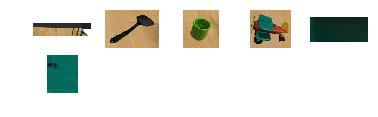

In [53]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 2,1')

In [54]:
move_base(1.5,.5,np.pi)

In [55]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

('i am at', [1.5331399815980442, 0.577002685304018, 0.9670894554166953], -90.37738374360629)
('gaze goal', 1, 1, 0.1)
('relative to robot', (0.5331399815980442, -0.422997314695982, -38.42875150427523))


True

('cX,cY', 591, 19)
[ 0.6590266 -0.5504474  1.4539213]
('cX,cY', 344, 274)
[0.0505395  0.07497359 1.0836831 ]
('cX,cY', 350, 271)
[0.04214358 0.06374859 1.0220104 ]
('cX,cY', 568, 269)
[0.5159851 0.0724475 1.1396172]
('cX,cY', 528, 175)
[ 0.49299896 -0.15048036  1.304583  ]
('cX,cY', 346, 52)
[ 0.07914083 -0.5487255   1.6247792 ]


True

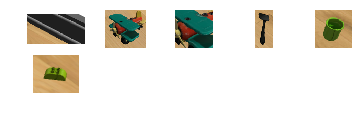

In [56]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 1.5,.5')

In [57]:
move_base(0,0,0)

In [60]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

('i am at', [0.8592715909640294, 0.3333751894791517, 0.9673016215619774], -166.69918432665278)
('gaze goal', 1, 1, 0.1)
('relative to robot', (-0.14072840903597061, -0.6666248105208483, -101.92045093074849))


True

('cX,cY', 333, 305)
[0.02517021 0.11591105 1.0531117 ]
('cX,cY', 334, 299)
[0.02313888 0.11708737 0.9960243 ]
('cX,cY', 30, 171)
[-0.6887326  -0.16182229  1.3234873 ]
('cX,cY', 402, 161)
[ 0.20172164 -0.18865925  1.3471636 ]
('cX,cY', 305, 130)
[-0.03547248 -0.27599135  1.404387  ]
('cX,cY', 119, 11)
[-0.37308273 -0.60489666  1.5060607 ]


True

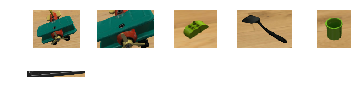

In [61]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 0,0')